# Model Predictive Control with Custom Trajectories

This notebook implements Model Predictive Control (MPC) algorithms for autonomous vehicle path tracking with custom trajectories. The implementation features both core path tracking functionality and a graphical user interface for trajectory design and MPC parameter tuning.

## About Model Predictive Control

Model Predictive Control is a control method that optimizes control actions over a finite prediction horizon by:
1. Predicting future system states based on a model
2. Optimizing control inputs to minimize a cost function
3. Applying only the first control input, then repeating the process

For autonomous vehicles, MPC helps follow a reference trajectory while respecting constraints like maximum steering angle and acceleration.

In [1]:
# Install required packages
!pip install numpy scipy matplotlib cvxpy
!pip install ipywidgets

In [2]:
# Install required packages if needed
# Uncomment the line below if running in a fresh environment
# !pip install numpy scipy matplotlib cvxpy

# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import cvxpy

# For GUI section (optional)
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Configure matplotlib for interactive plotting in the notebook
%matplotlib inline

## Angle Utility Functions

In [3]:
# Angle utility functions from utils/angle.py
import numpy as np
from scipy.spatial.transform import Rotation as Rot

def rot_mat_2d(angle):
    """Create 2D rotation matrix from an angle"""
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]

def angle_mod(x, zero_2_2pi=False, degree=False):
    """
    Angle modulo operation
    Default angle modulo range is [-pi, pi)
    """
    if isinstance(x, float):
        is_float = True
    else:
        is_float = False

    x = np.asarray(x).flatten()
    if degree:
        x = np.deg2rad(x)

    if zero_2_2pi:
        mod_angle = x % (2 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2 * np.pi) - np.pi

    if degree:
        mod_angle = np.rad2deg(mod_angle)

    if is_float:
        return mod_angle.item()
    else:
        return mod_angle

def pi_2_pi(angle):
    """Convert angle to range [-pi, pi)"""
    return angle_mod(angle)

## Cubic Spline Planner

In [4]:
# Cubic spline planner implementation from utils/cubic_spline_planner.py
class CubicSpline1D:
    """
    1D Cubic Spline class for interpolation
    """
    def __init__(self, x, y):
        h = np.diff(x)
        if np.any(h < 0):
            raise ValueError("x coordinates must be sorted in ascending order")

        self.a, self.b, self.c, self.d = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x

        # calc coefficient a
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h, self.a)
        self.c = np.linalg.solve(A, B)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            d = (self.c[i + 1] - self.c[i]) / (3.0 * h[i])
            b = 1.0 / h[i] * (self.a[i + 1] - self.a[i]) \
                - h[i] / 3.0 * (2.0 * self.c[i] + self.c[i + 1])
            self.d.append(d)
            self.b.append(b)

    def calc_position(self, x):
        """Calculate position at x"""
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        position = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return position

    def calc_first_derivative(self, x):
        """Calculate first derivative at x"""
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        dy = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return dy

    def calc_second_derivative(self, x):
        """Calculate second derivative at x"""
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        ddy = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return ddy

    def calc_third_derivative(self, x):
        """Calculate third derivative at x"""
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dddy = 6.0 * self.d[i]
        return dddy

    def __search_index(self, x):
        """Search data segment index"""
        import bisect
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """Calculate matrix A for spline coefficient c"""
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h, a):
        """Calculate matrix B for spline coefficient c"""
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / h[i + 1] - 3.0 * (a[i + 1] - a[i]) / h[i]
        return B


class CubicSpline2D:
    """
    2D Cubic Spline class for trajectory generation
    """
    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = CubicSpline1D(self.s, x)
        self.sy = CubicSpline1D(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """Calculate position at s"""
        x = self.sx.calc_position(s)
        y = self.sy.calc_position(s)
        return x, y

    def calc_curvature(self, s):
        """Calculate curvature at s"""
        dx = self.sx.calc_first_derivative(s)
        ddx = self.sx.calc_second_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        ddy = self.sy.calc_second_derivative(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """Calculate yaw angle at s"""
        dx = self.sx.calc_first_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    """
    Calculate spline course from waypoints
    Returns course position, yaw and curvature lists
    """
    sp = CubicSpline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

## Vehicle State and Parameters (Code)

In [5]:
# Vehicle model and state definitions from mpc.py

# State and input dimensions
NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5   # horizon length

# MPC parameters (default values)
R = np.diag([0.01, 0.01])   # input cost matrix
Rd = np.diag([0.01, 1.0])   # input difference cost matrix
Q = np.diag([1.0, 1.0, 0.5, 0.5])  # state cost matrix
Qf = Q  # state final matrix
GOAL_DIS = 1.5  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed
MAX_TIME = 500.0  # max simulation time

# Iterative parameter
MAX_ITER = 3  # Max iteration
DU_TH = 0.1  # iteration finish param

TARGET_SPEED = 10.0 / 3.6  # [m/s] target speed
N_IND_SEARCH = 10  # Search index number

DT = 0.2  # [s] time tick

# Vehicle parameters
LENGTH = 4.5  # [m]
WIDTH = 2.0  # [m]
BACKTOWHEEL = 1.0  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 1.0  # maximum accel [m/ss]

show_animation = True


class State:
    """
    Vehicle state class
    """
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None

## MPC Core Functions (Code)

In [6]:
# MPC core functions from mpc.py

def get_linear_model_matrix(v, phi, delta):
    """
    Create linearized model matrices
    """
    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * math.cos(phi)
    A[0, 3] = - DT * v * math.sin(phi)
    A[1, 2] = DT * math.sin(phi)
    A[1, 3] = DT * v * math.cos(phi)
    A[3, 2] = DT * math.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)

    C = np.zeros(NX)
    C[0] = DT * v * math.sin(phi) * phi
    C[1] = - DT * v * math.cos(phi) * phi
    C[3] = - DT * v * delta / (WB * math.cos(delta) ** 2)

    return A, B, C


def update_state(state, a, delta):
    """
    Update vehicle state with control inputs
    """
    # input check
    if delta >= MAX_STEER:
        delta = MAX_STEER
    elif delta <= -MAX_STEER:
        delta = -MAX_STEER

    state.x = state.x + state.v * math.cos(state.yaw) * DT
    state.y = state.y + state.v * math.sin(state.yaw) * DT
    state.yaw = state.yaw + state.v / WB * math.tan(delta) * DT
    state.v = state.v + a * DT

    if state.v > MAX_SPEED:
        state.v = MAX_SPEED
    elif state.v < MIN_SPEED:
        state.v = MIN_SPEED

    return state


def get_nparray_from_matrix(x):
    """
    Convert matrix to numpy array
    """
    return np.array(x).flatten()


def calc_nearest_index(state, cx, cy, cyaw, pind):
    """
    Calculate nearest point index to current state
    """
    dx = [state.x - icx for icx in cx[pind:(pind + N_IND_SEARCH)]]
    dy = [state.y - icy for icy in cy[pind:(pind + N_IND_SEARCH)]]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind) + pind

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def predict_motion(x0, oa, od, xref):
    """
    Predict vehicle motion with given control inputs
    """
    xbar = xref * 0.0
    for i, _ in enumerate(x0):
        xbar[i, 0] = x0[i]

    state = State(x=x0[0], y=x0[1], yaw=x0[3], v=x0[2])
    for (ai, di, i) in zip(oa, od, range(1, T + 1)):
        state = update_state(state, ai, di)
        xbar[0, i] = state.x
        xbar[1, i] = state.y
        xbar[2, i] = state.v
        xbar[3, i] = state.yaw

    return xbar


def iterative_linear_mpc_control(xref, x0, dref, oa, od):
    """
    MPC control with updating operational point iteratively
    """
    ox, oy, oyaw, ov = None, None, None, None

    if oa is None or od is None:
        oa = [0.0] * T
        od = [0.0] * T

    for i in range(MAX_ITER):
        xbar = predict_motion(x0, oa, od, xref)
        poa, pod = oa[:], od[:]
        oa, od, ox, oy, oyaw, ov = linear_mpc_control(xref, xbar, x0, dref)
        du = sum(abs(oa - poa)) + sum(abs(od - pod))  # calc u change value
        if du <= DU_TH:
            break
    else:
        print("Iterative is max iter")

    return oa, od, ox, oy, oyaw, ov


def linear_mpc_control(xref, xbar, x0, dref):
    """
    Linear MPC control
    xref: reference point
    xbar: operational point
    x0: initial state
    dref: reference steer angle
    """
    x = cvxpy.Variable((NX, T + 1))
    u = cvxpy.Variable((NU, T))

    cost = 0.0
    constraints = []

    for t in range(T):
        cost += cvxpy.quad_form(u[:, t], R)

        if t != 0:
            cost += cvxpy.quad_form(xref[:, t] - x[:, t], Q)

        A, B, C = get_linear_model_matrix(
            xbar[2, t], xbar[3, t], dref[0, t])
        constraints += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + C]

        if t < (T - 1):
            cost += cvxpy.quad_form(u[:, t + 1] - u[:, t], Rd)
            constraints += [cvxpy.abs(u[1, t + 1] - u[1, t]) <=
                            MAX_DSTEER * DT]

    cost += cvxpy.quad_form(xref[:, T] - x[:, T], Qf)

    constraints += [x[:, 0] == x0]
    constraints += [x[2, :] <= MAX_SPEED]
    constraints += [x[2, :] >= MIN_SPEED]
    constraints += [cvxpy.abs(u[0, :]) <= MAX_ACCEL]
    constraints += [cvxpy.abs(u[1, :]) <= MAX_STEER]

    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraints)
    prob.solve(solver=cvxpy.CLARABEL, verbose=False)

    if prob.status == cvxpy.OPTIMAL or prob.status == cvxpy.OPTIMAL_INACCURATE:
        ox = get_nparray_from_matrix(x.value[0, :])
        oy = get_nparray_from_matrix(x.value[1, :])
        ov = get_nparray_from_matrix(x.value[2, :])
        oyaw = get_nparray_from_matrix(x.value[3, :])
        oa = get_nparray_from_matrix(u.value[0, :])
        odelta = get_nparray_from_matrix(u.value[1, :])

    else:
        print("Error: Cannot solve mpc..")
        oa, odelta, ox, oy, oyaw, ov = None, None, None, None, None, None

    return oa, odelta, ox, oy, oyaw, ov

## Simulation Functions

In [7]:
def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", truckcolor="-k", ax=None):
    """
    Plot a car on a 2D surface
    
    Parameters:
    ----------
    x, y: position
    yaw: orientation
    steer: steering angle
    cabcolor, truckcolor: colors
    ax: matplotlib axes (optional)
    """
    # If ax is None, use current axes
    if ax is None:
        ax = plt.gca()
        
    outline = np.array([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                        [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.array([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                         [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                     [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.array([[math.cos(steer), math.sin(steer)],
                     [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T.dot(Rot2)).T
    fl_wheel = (fl_wheel.T.dot(Rot2)).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T.dot(Rot1)).T
    fl_wheel = (fl_wheel.T.dot(Rot1)).T

    outline = (outline.T.dot(Rot1)).T
    rr_wheel = (rr_wheel.T.dot(Rot1)).T
    rl_wheel = (rl_wheel.T.dot(Rot1)).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    ax.plot(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), truckcolor)
    ax.plot(np.array(fr_wheel[0, :]).flatten(),
             np.array(fr_wheel[1, :]).flatten(), truckcolor)
    ax.plot(np.array(rr_wheel[0, :]).flatten(),
             np.array(rr_wheel[1, :]).flatten(), truckcolor)
    ax.plot(np.array(fl_wheel[0, :]).flatten(),
             np.array(fl_wheel[1, :]).flatten(), truckcolor)
    ax.plot(np.array(rl_wheel[0, :]).flatten(),
             np.array(rl_wheel[1, :]).flatten(), truckcolor)
    ax.plot(x, y, "*")

def smooth_yaw(yaw):
    """
    Smooth yaw angle changes
    """
    for i in range(len(yaw) - 1):
        dyaw = yaw[i + 1] - yaw[i]

        while dyaw >= math.pi / 2.0:
            yaw[i + 1] -= math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

        while dyaw <= -math.pi / 2.0:
            yaw[i + 1] += math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

    return yaw

def calc_ref_trajectory(state, cx, cy, cyaw, ck, sp, dl, pind):
    """
    Calculate reference trajectory at current state
    """
    xref = np.zeros((NX, T + 1))
    dref = np.zeros((1, T + 1))
    ncourse = len(cx)

    ind, _ = calc_nearest_index(state, cx, cy, cyaw, pind)

    if pind >= ind:
        ind = pind

    xref[0, 0] = cx[ind]
    xref[1, 0] = cy[ind]
    xref[2, 0] = sp[ind]
    xref[3, 0] = cyaw[ind]
    dref[0, 0] = 0.0  # steer operational point should be 0

    travel = 0.0

    for i in range(T + 1):
        travel += abs(state.v) * DT
        dind = int(round(travel / dl))

        if (ind + dind) < ncourse:
            xref[0, i] = cx[ind + dind]
            xref[1, i] = cy[ind + dind]
            xref[2, i] = sp[ind + dind]
            xref[3, i] = cyaw[ind + dind]
            dref[0, i] = 0.0
        else:
            xref[0, i] = cx[ncourse - 1]
            xref[1, i] = cy[ncourse - 1]
            xref[2, i] = sp[ncourse - 1]
            xref[3, i] = cyaw[ncourse - 1]
            dref[0, i] = 0.0

    return xref, ind, dref

def calc_speed_profile(cx, cy, cyaw, target_speed):
    """
    Calculate speed profile
    """
    speed_profile = [target_speed] * len(cx)
    direction = 1.0  # forward

    # Set stop point
    for i in range(len(cx) - 1):
        dx = cx[i + 1] - cx[i]
        dy = cy[i + 1] - cy[i]

        move_direction = math.atan2(dy, dx)

        if dx != 0.0 and dy != 0.0:
            dangle = abs(pi_2_pi(move_direction - cyaw[i]))
            if dangle >= math.pi / 4.0:
                direction = -1.0
            else:
                direction = 1.0

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

    speed_profile[-1] = 0.0

    return speed_profile

def check_goal(state, goal, tind, nind):
    """
    Check if vehicle reaches goal
    """
    # check goal
    dx = state.x - goal[0]
    dy = state.y - goal[1]
    d = math.hypot(dx, dy)

    isgoal = (d <= GOAL_DIS)

    if abs(tind - nind) >= 5:
        isgoal = False

    isstop = (abs(state.v) <= STOP_SPEED)

    if isgoal and isstop:
        return True

    return False

## Trajectory Configuration

In [8]:
# Trajectory configurations from trajectory_config.py

def straight_path():
    """Straight course path"""
    ax = [0.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]
    ay = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    waypoints = list(zip(ax, ay))
    return waypoints

def wavy_path():
    """Slightly curved path"""
    ax = [0.0, -10.0, -20.0, -40.0, -50.0, -60.0, -70.0]
    ay = [0.0, -1.0, 1.0, 0.0, -1.0, 1.0, 0.0]
    waypoints = list(zip(ax, ay))
    return waypoints

def spline_path():
    """Forward course path"""
    ax = [0.0, 60.0, 125.0, 50.0, 75.0, 30.0, -10.0]
    ay = [0.0, 0.0, 50.0, 65.0, 30.0, 50.0, -20.0]
    waypoints = list(zip(ax, ay))
    return waypoints

def circular_path():
    """Circular path"""
    radius = 30.0
    center_x, center_y = 50.0, 0.0
    
    # Generate points along a circle
    angles = np.linspace(0, 2*np.pi, 12)
    waypoints = [(center_x + radius * np.cos(angle), 
                  center_y + radius * np.sin(angle)) for angle in angles]
    
    return waypoints

def figure_eight_path():
    """Figure-8 path"""
    radius = 30.0
    
    # Generate points for the figure-8
    angles = np.linspace(0, 2*np.pi, 16)
    waypoints = []
    
    for angle in angles:
        # Figure-8 parametric equations
        x = radius * np.cos(angle)
        y = radius/2 * np.sin(2*angle)
        waypoints.append((x, y))
    
    return waypoints

def slalom_path():
    """Slalom path"""
    waypoints = [
        (0.0, 0.0),
        (20.0, 10.0),
        (40.0, -10.0),
        (60.0, 10.0),
        (80.0, -10.0),
        (100.0, 0.0)
    ]
    return waypoints

def custom_path():
    """Custom path - modify this for your own trajectory"""
    waypoints = [
        (0.0, 0.0),    # Starting point
        (10.0, 10.0),  # Second point
        (20.0, 0.0),   # Third point
        (30.0, -10.0), # Fourth point
        (40.0, 0.0)    # Fifth point
    ]
    return waypoints

# Dictionary mapping trajectory names to functions
TRAJECTORIES = {
    "Straight": straight_path,
    "Wavy": wavy_path,
    "Spline": spline_path,
    "Circular": circular_path,
    "Eternity": figure_eight_path,
    "Slalom": slalom_path,
    "Custom": custom_path,
}

# Default trajectory to use
DEFAULT_TRAJECTORY = "Circular"

## Main Simulation Function

In [9]:
def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state, show_animation=True):
    """
    Simulation with a separate Tkinter window for animation
    """
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    import tkinter as tk
    
    # Create data containers
    goal = [cx[-1], cy[-1]]
    state = initial_state
    
    # Initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0
        
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None
    cyaw = smooth_yaw(cyaw)
    
    # Setup animation window if needed
    root = None
    canvas = None
    animation_fig = None
    animation_ax = None
    
    if show_animation:
        # Create Tkinter root window
        root = tk.Tk()
        root.title("MPC Animation")
        root.geometry("800x800")
        
        # Create matplotlib figure and embed in Tkinter
        animation_fig = plt.Figure(figsize=(10, 8))
        canvas = FigureCanvasTkAgg(animation_fig, master=root)
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        animation_ax = animation_fig.add_subplot(111)
        
        # Setup close handling to avoid kernel crashes
        def on_closing():
            root.quit()
            root.destroy()
        root.protocol("WM_DELETE_WINDOW", on_closing)
        
        # Make sure the window appears on top (ADD THESE LINES)
        root.lift()           # Bring window to top
        root.attributes('-topmost', True)  # Keep on top
        root.after_idle(root.attributes, '-topmost', False)  # Allow to go behind other windows after
        root.focus_force()    # Force focus on this window
        
        # Make sure the window is shown
        root.update()
    
    # Simulation loop
    try:
        while MAX_TIME >= time:
            # Generate reference trajectory
            xref, target_ind, dref = calc_ref_trajectory(
                state, cx, cy, cyaw, ck, sp, dl, target_ind)

            # Current state
            x0 = [state.x, state.y, state.v, state.yaw]

            # MPC control
            oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
                xref, x0, dref, oa, odelta)

            # Apply first control input
            di, ai = 0.0, 0.0
            if odelta is not None:
                di, ai = odelta[0], oa[0]
                state = update_state(state, ai, di)

            # Update time and store data
            time = time + DT
            x.append(state.x)
            y.append(state.y)
            yaw.append(state.yaw)
            v.append(state.v)
            t.append(time)
            d.append(di)
            a.append(ai)
            
            # Update animation if needed
            if show_animation and root and root.winfo_exists():
                animation_ax.clear()
                if ox is not None:
                    animation_ax.plot(ox, oy, "xr", label="MPC")
                animation_ax.plot(cx, cy, "-r", label="course")
                animation_ax.plot(x, y, "ob", label="trajectory")
                animation_ax.plot(xref[0, :], xref[1, :], "xk", label="xref")
                animation_ax.plot(cx[target_ind], cy[target_ind], "xg", label="target")
                plot_car(state.x, state.y, state.yaw, steer=di, ax=animation_ax)
                animation_ax.axis("equal")
                animation_ax.grid(True)
                animation_ax.set_title("Time[s]:" + str(round(time, 2))
                          + ", speed[km/h]:" + str(round(state.v * 3.6, 2)))
                animation_ax.legend()
                canvas.draw()
                
                # Process Tkinter events and add slight delay
                root.update()
                root.after(10)  # 10ms delay for visualization 
                
            # Check goal
            if check_goal(state, goal, target_ind, len(cx)):
                print("Goal")
                break
    except Exception as e:
        print(f"Simulation error: {e}")
    finally:
        # Clean up resources
        if root is not None and root.winfo_exists():
            try:
                root.quit()
                root.destroy()
            except:
                pass
        if animation_fig is not None:
            try:
                plt.close(animation_fig)
            except:
                pass
    
    return t, x, y, yaw, v, d, a

## Create Custom Trajectory Function

In [10]:
def create_custom_trajectory(waypoints, dl=1.0):
    """
    Create a trajectory from user-defined waypoints.
    
    Parameters
    ----------
    waypoints : list of tuples
        List of (x, y) coordinates defining the waypoints of the trajectory
    dl : float, optional
        Distance between interpolated points, by default 1.0
        
    Returns
    -------
    tuple
        (cx, cy, cyaw, ck) - course x, y, yaw, and curvature lists
    """
    ax = [point[0] for point in waypoints]
    ay = [point[1] for point in waypoints]
    
    cx, cy, cyaw, ck, _ = calc_spline_course(ax, ay, ds=dl)
    
    return cx, cy, cyaw, ck

## Function to Run MPC Simulation

In [11]:
def run_mpc_simulation(trajectory_name, target_speed_kmh=10.0, dl=1.0, animation=True):
    """Run MPC simulation with selected trajectory in a popup window"""
    # Convert km/h to m/s
    target_speed = target_speed_kmh / 3.6
    
    # Get waypoints
    waypoints = TRAJECTORIES[trajectory_name]()
    
    # Create trajectory
    cx, cy, cyaw, ck = create_custom_trajectory(waypoints, dl)
    
    # Calculate speed profile
    sp = calc_speed_profile(cx, cy, cyaw, target_speed)
    
    # Set initial state
    initial_state = State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)
    
    # Print info
    print(f"Running simulation for '{trajectory_name}' trajectory")
    print(f"Target speed: {target_speed_kmh} km/h")
    
    # Create separate window for animation if needed
    if animation:
        import matplotlib
        orig_backend = matplotlib.get_backend()
        matplotlib.use('TkAgg')  # Use TkAgg for popup window
    
    # Run simulation
    t, x, y, yaw, v, d, a = do_simulation(
        cx, cy, cyaw, ck, sp, dl, initial_state, show_animation=animation)
    
    # Return to original backend
    if animation:
        matplotlib.use(orig_backend)
    
    # Plot result summary (will be shown inline)
    plt.figure(figsize=(12, 9))
    plt.subplot(3, 1, 1)
    plt.plot(cx, cy, "-r", label="reference")
    plt.plot(x, y, "-b", label="trajectory")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(t, [speed * 3.6 for speed in v], "-r", label="speed")
    plt.grid(True)
    plt.xlabel("Time [s]")
    plt.ylabel("Speed [km/h]")
    
    plt.subplot(3, 1, 3)
    plt.plot(t, [np.rad2deg(steer) for steer in d], "-r", label="steering")
    plt.grid(True)
    plt.xlabel("Time [s]")
    plt.ylabel("Steering [deg]")
    
    plt.tight_layout()
    plt.show()
    
    return t, x, y, yaw, v, d, a

## Example Usage

Running simulation for 'Circular' trajectory
Target speed: 15.0 km/h
Iterative is max iter
Iterative is max iter
Iterative is max iter
Iterative is max iter
Iterative is max iter
Iterative is max iter
Iterative is max iter
Goal


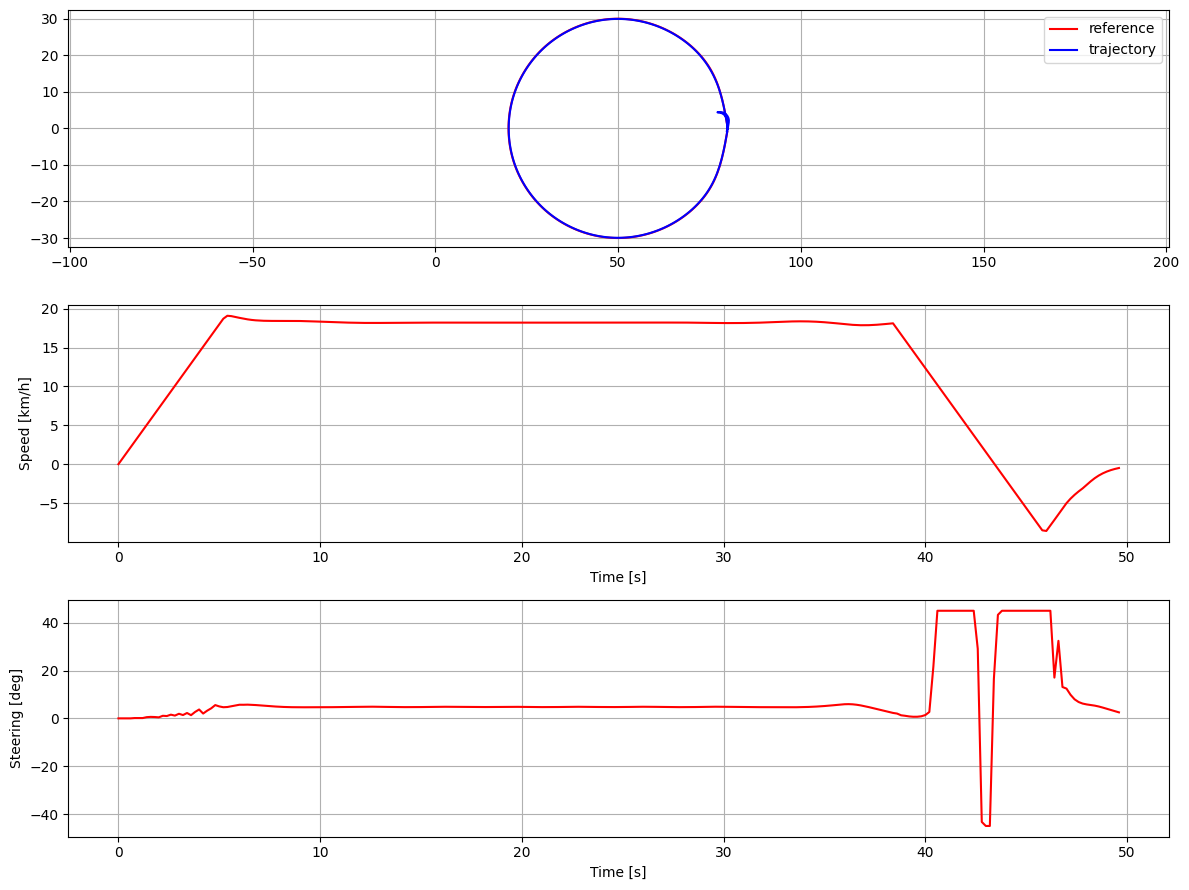

([0.0,
  0.2,
  0.4,
  0.6000000000000001,
  0.8,
  1.0,
  1.2,
  1.4,
  1.5999999999999999,
  1.7999999999999998,
  1.9999999999999998,
  2.1999999999999997,
  2.4,
  2.6,
  2.8000000000000003,
  3.0000000000000004,
  3.2000000000000006,
  3.400000000000001,
  3.600000000000001,
  3.800000000000001,
  4.000000000000001,
  4.200000000000001,
  4.400000000000001,
  4.600000000000001,
  4.800000000000002,
  5.000000000000002,
  5.200000000000002,
  5.400000000000002,
  5.600000000000002,
  5.8000000000000025,
  6.000000000000003,
  6.200000000000003,
  6.400000000000003,
  6.600000000000003,
  6.800000000000003,
  7.0000000000000036,
  7.200000000000004,
  7.400000000000004,
  7.600000000000004,
  7.800000000000004,
  8.000000000000004,
  8.200000000000003,
  8.400000000000002,
  8.600000000000001,
  8.8,
  9.0,
  9.2,
  9.399999999999999,
  9.599999999999998,
  9.799999999999997,
  9.999999999999996,
  10.199999999999996,
  10.399999999999995,
  10.599999999999994,
  10.799999999999994,

In [12]:
# Run simulation with popup window
trajectory_name = "Circular"
target_speed = 15.0  # km/h
dl = 1.0

run_mpc_simulation(trajectory_name, target_speed, dl, animation=True)

## Interactive Parameter Testing

In [ ]:
from ipywidgets import interact, FloatSlider, Dropdown, Checkbox

def interactive_mpc_test(trajectory=DEFAULT_TRAJECTORY, 
                         speed=10.0, 
                         dl=1.0,
                         q1=1.0,
                         q2=1.0,
                         q3=0.5,
                         q4=0.5,
                         r1=0.01,
                         r2=0.01,
                         rd1=0.01,
                         rd2=1.0,
                         prediction_horizon=5,
                         show_animation=True):
    """Interactive MPC testing with adjustable parameters"""
    global T, Q, R, Rd, DT
    
    # Set MPC parameters
    T = prediction_horizon
    Q = np.diag([q1, q2, q3, q4])
    Qf = Q
    R = np.diag([r1, r2])
    Rd = np.diag([rd1, rd2])
    
    # Run simulation
    run_mpc_simulation(trajectory, speed, dl, animation=show_animation)
    
# Create interactive widgets
interact(interactive_mpc_test,
         trajectory=Dropdown(options=list(TRAJECTORIES.keys()), value=DEFAULT_TRAJECTORY, description='Trajectory:'),
         speed=FloatSlider(min=5.0, max=30.0, step=1.0, value=10.0, description='Speed (km/h):'),
         dl=FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='Path Resolution:'),
         q1=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Q1 (x position):'),
         q2=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Q2 (y position):'),
         q3=FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5, description='Q3 (velocity):'),
         q4=FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5, description='Q4 (yaw):'),
         r1=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01, description='R1 (accel):'),
         r2=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01, description='R2 (steering):'),
         rd1=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01, description='Rd1 (accel change):'),
         rd2=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Rd2 (steering change):'),
         prediction_horizon=FloatSlider(min=3, max=20, step=1, value=5, description='Horizon:'),
         show_animation=Checkbox(value=True, description='Show Animation'))

## Custom Interactive Trajectory Designer

In [ ]:
from matplotlib.widgets import Button

class InteractiveTrajectoryDesigner:
    def __init__(self):
        self.waypoints = []
        self.fig, self.ax = plt.subplots(figsize=(10, 8))
        self.ax.set_xlim(-100, 100)
        self.ax.set_ylim(-100, 100)
        self.ax.grid(True)
        self.ax.set_title('Click to add waypoints - ESC to clear - ENTER to run simulation')
        self.ax.set_xlabel('X [m]')
        self.ax.set_ylabel('Y [m]')
        
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.canvas.mpl_connect('key_press_event', self.onkey)
        
        plt.show()
    
    def onclick(self, event):
        if event.inaxes != self.ax:
            return
        
        self.waypoints.append((event.xdata, event.ydata))
        self.update_plot()
    
    def onkey(self, event):
        if event.key == 'escape':
            self.waypoints = []
            self.update_plot()
        elif event.key == 'enter' and len(self.waypoints) >= 3:
            self.run_simulation()
    
    def update_plot(self):
        self.ax.clear()
        self.ax.set_xlim(-100, 100)
        self.ax.set_ylim(-100, 100)
        self.ax.grid(True)
        
        if self.waypoints:
            x_points = [p[0] for p in self.waypoints]
            y_points = [p[1] for p in self.waypoints]
            self.ax.plot(x_points, y_points, 'bo-', label="Waypoints")
            
            # Annotate points with their index
            for i, (x, y) in enumerate(self.waypoints):
                self.ax.annotate(str(i), (x, y), textcoords="offset points", 
                               xytext=(0, 10), ha='center')
        
        self.ax.set_title(f'Custom Trajectory Designer - {len(self.waypoints)} points added\nESC to clear - ENTER to run simulation')
        self.ax.set_xlabel('X [m]')
        self.ax.set_ylabel('Y [m]')
        plt.draw()
    
    def run_simulation(self):
        if len(self.waypoints) < 3:
            print("Need at least 3 points for a valid trajectory")
            return
        
        # Update TRAJECTORIES dictionary's "Custom" entry
        TRAJECTORIES["Custom"] = lambda: self.waypoints.copy()
        
        plt.close(self.fig)  # Close the interactive plot
        
        # Run simulation with custom trajectory
        run_mpc_simulation("Custom", target_speed=15.0, dl=1.0, animation=True)

# Create and run the interactive trajectory designer
# designer = InteractiveTrajectoryDesigner()

# GUI Implementation (Optional Section)

This section implements a graphical user interface (GUI) using Tkinter for:
- Interactive trajectory design
- MPC parameter tuning
- Vehicle parameter adjustment
- Simulation visualization

**Important**: The GUI runs in a separate window and is not integrated with Jupyter widgets. You need to run the cell below to launch the GUI application.

In [ ]:
def launch_gui():
    """
    Launch the MPC Trajectory Designer GUI
    
    This function starts the GUI application in a separate window.
    The GUI provides more advanced features than the Jupyter notebook interface.
    """
    # Import tkinter and related modules for GUI
    import tkinter as tk
    from tkinter import ttk, messagebox, scrolledtext
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    
    class MPCTrajectoryGUI:
        def __init__(self, root):
            self.root = root
            self.root.title("MPC Trajectory Designer with Parameter Tuning")
            self.root.geometry("1400x900")
            
            # Trajectory points
            self.waypoints = []
            self.last_point_marked = False
            
            # MPC Parameters - Default values from the original code
            self.mpc_params = {
                "T": 5,                       # Prediction horizon
                "DT": 0.2,                    # Time step
                "Q1": 1.0,                    # State cost - x position
                "Q2": 1.0,                    # State cost - y position
                "Q3": 0.5,                    # State cost - velocity
                "Q4": 0.5,                    # State cost - yaw
                "R1": 0.01,                   # Input cost - acceleration
                "R2": 0.01,                   # Input cost - steering
                "Rd1": 0.01,                  # Input difference cost - acceleration
                "Rd2": 1.0,                   # Input difference cost - steering
                "MAX_ITER": 3,                # Maximum iterations for MPC
                "MAX_STEER": 45.0,            # Maximum steering angle [deg]
                "MAX_DSTEER": 30.0,           # Maximum steering speed [deg/s]
                "MAX_SPEED": 55.0,            # Maximum speed [km/h]
                "MAX_ACCEL": 1.0,             # Maximum acceleration [m/s²]
                "WB": 2.5                     # Wheelbase [m]
            }
            
            # Create GUI components
            self.create_widgets()
            
            # Default values
            self.dl_var.set("1.0")
            self.speed_var.set("10.0")         # 10.0 / 3.6 m/s (as in the original code)
            self.trajectory_var.set("Circular")
            self.update_trajectory_preview()
        
        def create_widgets(self):
            # Main frame
            main_frame = ttk.Frame(self.root, padding="10")
            main_frame.pack(fill=tk.BOTH, expand=True)
            
            # Create a horizontal paned window
            paned_window = ttk.PanedWindow(main_frame, orient=tk.HORIZONTAL)
            paned_window.pack(fill=tk.BOTH, expand=True)
            
            # Left side: Controls
            control_frame = ttk.Frame(paned_window)
            paned_window.add(control_frame, weight=1)
            
            # Right side: Plots
            plot_frame = ttk.LabelFrame(paned_window, text="Trajectory Preview", padding="10")
            paned_window.add(plot_frame, weight=2)
            
            # Create tabbed interface for controls
            notebook = ttk.Notebook(control_frame)
            notebook.pack(fill=tk.BOTH, expand=True)
            
            # Tab 1: Trajectory Controls
            trajectory_tab = ttk.Frame(notebook, padding="10")
            notebook.add(trajectory_tab, text="Trajectory")
            
            # Tab 2: MPC Parameters
            mpc_params_tab = ttk.Frame(notebook, padding="10")
            notebook.add(mpc_params_tab, text="MPC Parameters")
            
            # Tab 3: Vehicle Parameters
            vehicle_params_tab = ttk.Frame(notebook, padding="10")
            notebook.add(vehicle_params_tab, text="Vehicle Parameters")
            
            # Tab 4: Simulation Log
            log_tab = ttk.Frame(notebook, padding="10")
            notebook.add(log_tab, text="Simulation Log")
            
            # ======== TRAJECTORY TAB =========
            
            # Predefined trajectories selector
            ttk.Label(trajectory_tab, text="Predefined Trajectories:").pack(anchor=tk.W, pady=(0, 5))
            self.trajectory_var = tk.StringVar()
            trajectory_combo = ttk.Combobox(trajectory_tab, textvariable=self.trajectory_var, 
                                            values=list(TRAJECTORIES.keys()), state="readonly")
            trajectory_combo.pack(fill=tk.X, pady=(0, 10))
            trajectory_combo.bind("<<ComboboxSelected>>", lambda e: self.update_trajectory_preview())
            
            # Parameters
            params_frame = ttk.LabelFrame(trajectory_tab, text="Trajectory Generation Parameter", padding="10")
            params_frame.pack(fill=tk.X, pady=(0, 10))
            
            # DL parameter
            dl_frame = ttk.Frame(params_frame)
            dl_frame.pack(fill=tk.X, pady=5)
            ttk.Label(dl_frame, text="Points Distance (dl):").pack(side=tk.LEFT)
            self.dl_var = tk.StringVar()
            ttk.Entry(dl_frame, textvariable=self.dl_var, width=10).pack(side=tk.RIGHT)
            
            # Speed parameter
            speed_frame = ttk.Frame(params_frame)
            speed_frame.pack(fill=tk.X, pady=5)
            ttk.Label(speed_frame, text="Reference Speed (km/h):").pack(side=tk.LEFT)
            self.speed_var = tk.StringVar()
            ttk.Entry(speed_frame, textvariable=self.speed_var, width=10).pack(side=tk.RIGHT)
            
            preview_frame = ttk.Frame(params_frame)
            preview_frame.pack(fill=tk.X, pady=5)
            ttk.Button(preview_frame, text="Update Preview", command=self.update_trajectory_preview).pack(side=tk.LEFT, padx=2)

            
            # Custom trajectory editor
            custom_frame = ttk.LabelFrame(trajectory_tab, text="Custom Trajectory Editor", padding="10")
            custom_frame.pack(fill=tk.X, expand=False, pady=(0, 10), ipady=5)
            
            ttk.Label(custom_frame, text="Define your own trajectory by multiple clicking on the plot").pack()
            ttk.Label(custom_frame, text="(Plot area is fixed. You can change it in the code if needed.)").pack()
            
            # Buttons for custom trajectory
            buttons_frame = ttk.Frame(custom_frame)
            buttons_frame.pack(fill=tk.X, pady=5)
            
            ttk.Button(buttons_frame, text="Clear Points", command=self.clear_points).pack(side=tk.LEFT, padx=2)
            ttk.Button(buttons_frame, text="Use These Points", command=self.use_custom_points, width =30).pack(side=tk.LEFT, padx=2)

            # Simulation buttons
            sim_frame = ttk.Frame(trajectory_tab)
            sim_frame.pack(fill=tk.X, pady=10)
            
            tk.Button(sim_frame, text="Run Simulation", command=self.run_simulation, 
            height=3, font=("Arial", 14, "bold"), bg="#4CAF50", fg="Black").pack(fill=tk.X, pady=15)        
            # ======== MPC PARAMETERS TAB =========
            
            # Create a canvas with scrollbar for MPC parameters
            canvas_frame = ttk.Frame(mpc_params_tab)
            canvas_frame.pack(fill=tk.BOTH, expand=True)
            
            canvas = tk.Canvas(canvas_frame)
            scrollbar = ttk.Scrollbar(canvas_frame, orient="vertical", command=canvas.yview)
            scrollable_frame = ttk.Frame(canvas)
            
            scrollable_frame.bind(
                "<Configure>",
                lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
            )
            
            canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
            canvas.configure(yscrollcommand=scrollbar.set)
            
            canvas.pack(side="left", fill="both", expand=True)
            scrollbar.pack(side="right", fill="y")
            
            # MPC Parameters - Prediction and Control
            mpc_pred_frame = ttk.LabelFrame(scrollable_frame, text="Prediction and Control", padding=10)
            mpc_pred_frame.pack(fill=tk.X, padx=5, pady=5)
            
            # T - Prediction Horizon
            T_frame = ttk.Frame(mpc_pred_frame)
            T_frame.pack(fill=tk.X, pady=2)
            ttk.Label(T_frame, text="Prediction Horizon (T):").pack(side=tk.LEFT)
            self.T_var = tk.StringVar(value=str(self.mpc_params["T"]))
            ttk.Entry(T_frame, textvariable=self.T_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(T_frame, text="steps").pack(side=tk.RIGHT, padx=(0, 5))
            
            # DT - Time Step
            DT_frame = ttk.Frame(mpc_pred_frame)
            DT_frame.pack(fill=tk.X, pady=2)
            ttk.Label(DT_frame, text="Time Step (DT):").pack(side=tk.LEFT)
            self.DT_var = tk.StringVar(value=str(self.mpc_params["DT"]))
            ttk.Entry(DT_frame, textvariable=self.DT_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(DT_frame, text="seconds").pack(side=tk.RIGHT, padx=(0, 5))
            
            # MAX_ITER - Max iterations
            MAX_ITER_frame = ttk.Frame(mpc_pred_frame)
            MAX_ITER_frame.pack(fill=tk.X, pady=2)
            ttk.Label(MAX_ITER_frame, text="Max Iterations:").pack(side=tk.LEFT)
            self.MAX_ITER_var = tk.StringVar(value=str(self.mpc_params["MAX_ITER"]))
            ttk.Entry(MAX_ITER_frame, textvariable=self.MAX_ITER_var, width=10).pack(side=tk.RIGHT)
            
            # MPC Parameters - Cost Matrices
            cost_frame = ttk.LabelFrame(scrollable_frame, text="Cost Matrices", padding=10)
            cost_frame.pack(fill=tk.X, padx=5, pady=5)
            
            # State cost matrix Q
            ttk.Label(cost_frame, text="State Cost Matrix (Q):", font=("", 10, "bold")).pack(anchor=tk.W, pady=(0, 5))
            
            # Q1 - x position weight
            Q1_frame = ttk.Frame(cost_frame)
            Q1_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Q1_frame, text="Q1 (x position):").pack(side=tk.LEFT)
            self.Q1_var = tk.StringVar(value=str(self.mpc_params["Q1"]))
            ttk.Entry(Q1_frame, textvariable=self.Q1_var, width=10).pack(side=tk.RIGHT)
            
            # Q2 - y position weight
            Q2_frame = ttk.Frame(cost_frame)
            Q2_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Q2_frame, text="Q2 (y position):").pack(side=tk.LEFT)
            self.Q2_var = tk.StringVar(value=str(self.mpc_params["Q2"]))
            ttk.Entry(Q2_frame, textvariable=self.Q2_var, width=10).pack(side=tk.RIGHT)
            
            # Q3 - velocity weight
            Q3_frame = ttk.Frame(cost_frame)
            Q3_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Q3_frame, text="Q3 (velocity):").pack(side=tk.LEFT)
            self.Q3_var = tk.StringVar(value=str(self.mpc_params["Q3"]))
            ttk.Entry(Q3_frame, textvariable=self.Q3_var, width=10).pack(side=tk.RIGHT)
            
            # Q4 - yaw weight
            Q4_frame = ttk.Frame(cost_frame)
            Q4_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Q4_frame, text="Q4 (yaw):").pack(side=tk.LEFT)
            self.Q4_var = tk.StringVar(value=str(self.mpc_params["Q4"]))
            ttk.Entry(Q4_frame, textvariable=self.Q4_var, width=10).pack(side=tk.RIGHT)
            
            # Input cost matrix R
            ttk.Label(cost_frame, text="Input Cost Matrix (R):", font=("", 10, "bold")).pack(anchor=tk.W, pady=(10, 5))
            
            # R1 - acceleration weight
            R1_frame = ttk.Frame(cost_frame)
            R1_frame.pack(fill=tk.X, pady=2)
            ttk.Label(R1_frame, text="R1 (acceleration):").pack(side=tk.LEFT)
            self.R1_var = tk.StringVar(value=str(self.mpc_params["R1"]))
            ttk.Entry(R1_frame, textvariable=self.R1_var, width=10).pack(side=tk.RIGHT)
            
            # R2 - steering weight
            R2_frame = ttk.Frame(cost_frame)
            R2_frame.pack(fill=tk.X, pady=2)
            ttk.Label(R2_frame, text="R2 (steering):").pack(side=tk.LEFT)
            self.R2_var = tk.StringVar(value=str(self.mpc_params["R2"]))
            ttk.Entry(R2_frame, textvariable=self.R2_var, width=10).pack(side=tk.RIGHT)
            
            # Input difference cost matrix Rd
            ttk.Label(cost_frame, text="Input Difference Cost Matrix (Rd):", font=("", 10, "bold")).pack(anchor=tk.W, pady=(10, 5))
            
            # Rd1 - acceleration difference weight
            Rd1_frame = ttk.Frame(cost_frame)
            Rd1_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Rd1_frame, text="Rd1 (accel diff):").pack(side=tk.LEFT)
            self.Rd1_var = tk.StringVar(value=str(self.mpc_params["Rd1"]))
            ttk.Entry(Rd1_frame, textvariable=self.Rd1_var, width=10).pack(side=tk.RIGHT)
            
            # Rd2 - steering difference weight
            Rd2_frame = ttk.Frame(cost_frame)
            Rd2_frame.pack(fill=tk.X, pady=2)
            ttk.Label(Rd2_frame, text="Rd2 (steering diff):").pack(side=tk.LEFT)
            self.Rd2_var = tk.StringVar(value=str(self.mpc_params["Rd2"]))
            ttk.Entry(Rd2_frame, textvariable=self.Rd2_var, width=10).pack(side=tk.RIGHT)
            
            # Buttons for MPC parameters
            mpc_buttons_frame = ttk.Frame(scrollable_frame)
            mpc_buttons_frame.pack(fill=tk.X, pady=10)
            
            ttk.Button(mpc_buttons_frame, text="Reset to Default", command=self.reset_mpc_params).pack(side=tk.LEFT, padx=5)
            ttk.Button(mpc_buttons_frame, text="Apply Parameters", command=self.apply_mpc_params).pack(side=tk.LEFT, padx=5)
            
            # ======== VEHICLE PARAMETERS TAB =========
            
            vehicle_frame = ttk.LabelFrame(vehicle_params_tab, text="Vehicle Constraints", padding=10)
            vehicle_frame.pack(fill=tk.X, padx=5, pady=5)
            
            # MAX_STEER - Maximum steering angle
            MAX_STEER_frame = ttk.Frame(vehicle_frame)
            MAX_STEER_frame.pack(fill=tk.X, pady=2)
            ttk.Label(MAX_STEER_frame, text="Max Steering Angle:").pack(side=tk.LEFT)
            self.MAX_STEER_var = tk.StringVar(value=str(self.mpc_params["MAX_STEER"]))
            ttk.Entry(MAX_STEER_frame, textvariable=self.MAX_STEER_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(MAX_STEER_frame, text="degrees").pack(side=tk.RIGHT, padx=(0, 5))
            
            # MAX_DSTEER - Maximum steering speed
            MAX_DSTEER_frame = ttk.Frame(vehicle_frame)
            MAX_DSTEER_frame.pack(fill=tk.X, pady=2)
            ttk.Label(MAX_DSTEER_frame, text="Max Steering Speed:").pack(side=tk.LEFT)
            self.MAX_DSTEER_var = tk.StringVar(value=str(self.mpc_params["MAX_DSTEER"]))
            ttk.Entry(MAX_DSTEER_frame, textvariable=self.MAX_DSTEER_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(MAX_DSTEER_frame, text="degrees/s").pack(side=tk.RIGHT, padx=(0, 5))
            
            # MAX_SPEED - Maximum speed
            MAX_SPEED_frame = ttk.Frame(vehicle_frame)
            MAX_SPEED_frame.pack(fill=tk.X, pady=2)
            ttk.Label(MAX_SPEED_frame, text="Max Speed:").pack(side=tk.LEFT)
            self.MAX_SPEED_var = tk.StringVar(value=str(self.mpc_params["MAX_SPEED"]))
            ttk.Entry(MAX_SPEED_frame, textvariable=self.MAX_SPEED_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(MAX_SPEED_frame, text="km/h").pack(side=tk.RIGHT, padx=(0, 5))
            
            # MAX_ACCEL - Maximum acceleration
            MAX_ACCEL_frame = ttk.Frame(vehicle_frame)
            MAX_ACCEL_frame.pack(fill=tk.X, pady=2)
            ttk.Label(MAX_ACCEL_frame, text="Max Acceleration:").pack(side=tk.LEFT)
            self.MAX_ACCEL_var = tk.StringVar(value=str(self.mpc_params["MAX_ACCEL"]))
            ttk.Entry(MAX_ACCEL_frame, textvariable=self.MAX_ACCEL_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(MAX_ACCEL_frame, text="m/s²").pack(side=tk.RIGHT, padx=(0, 5))
            
            # Vehicle physical properties
            vehicle_phys_frame = ttk.LabelFrame(vehicle_params_tab, text="Vehicle Physical Properties", padding=10)
            vehicle_phys_frame.pack(fill=tk.X, padx=5, pady=5)
            
            # WB - Wheelbase
            WB_frame = ttk.Frame(vehicle_phys_frame)
            WB_frame.pack(fill=tk.X, pady=2)
            ttk.Label(WB_frame, text="Wheelbase (WB):").pack(side=tk.LEFT)
            self.WB_var = tk.StringVar(value=str(self.mpc_params["WB"]))
            ttk.Entry(WB_frame, textvariable=self.WB_var, width=10).pack(side=tk.RIGHT)
            ttk.Label(WB_frame, text="m").pack(side=tk.RIGHT, padx=(0, 5))
            
            # Apply vehicle parameters button
            vehicle_button_frame = ttk.Frame(vehicle_params_tab)
            vehicle_button_frame.pack(fill=tk.X, pady=10)
            ttk.Button(vehicle_button_frame, text="Apply Vehicle Parameters", 
                    command=self.apply_vehicle_params).pack(side=tk.LEFT, padx=5)
            
            # ======== LOG TAB =========
            
            # Create a text widget for logging
            self.log_text = scrolledtext.ScrolledText(log_tab, wrap=tk.WORD, width=50, height=20)
            self.log_text.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
            self.log_text.insert(tk.END, "Simulation log will be displayed here...\n")
            self.log_text.config(state=tk.DISABLED)
            
            # ======== PLOT FRAME =========
            
            # Create matplotlib figure
            self.fig = plt.Figure(figsize=(8, 6))
            self.ax = self.fig.add_subplot(111)
            self.ax.set_xlabel("X [m]")
            self.ax.set_ylabel("Y [m]")
            self.ax.grid(True)
            self.ax.set_aspect('equal')
            
            # Add the figure to the tkinter window
            self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
            self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
            
            # Connect mouse click event
            self.canvas.mpl_connect('button_press_event', self.on_click)
        
        def log_message(self, message):
            """Add message to the log tab"""
            self.log_text.config(state=tk.NORMAL)
            self.log_text.insert(tk.END, message + "\n")
            self.log_text.see(tk.END)
            self.log_text.config(state=tk.DISABLED)
        
        def on_click(self, event):
            """Handle click event on the plot to add points for custom trajectory"""
            if event.inaxes == self.ax and not self.last_point_marked:
                # Only add points if we haven't marked a last point
                self.waypoints.append((event.xdata, event.ydata))
                self.update_plot_with_custom_points()
        
        def clear_points(self):
            """Clear all custom points"""
            self.waypoints = []
            self.last_point_marked = False
            self.update_plot_with_custom_points()
        
        def use_custom_points(self):
            """Switch to using custom points for simulation"""
            if len(self.waypoints) < 3:
                messagebox.showwarning("Warning", "Please add at least 3 points for a valid trajectory.")
                return
            
            # Set the trajectories combobox to "custom"
            self.trajectory_var.set("Custom")
            
            # Update TRAJECTORIES dictionary's "custom" entry with a new function
            waypoints = self.waypoints.copy()
            TRAJECTORIES["Custom"] = lambda: waypoints
            
            self.log_message(f"Custom trajectory with {len(self.waypoints)} points set.")
            self.update_trajectory_preview()
        
        def update_plot_with_custom_points(self):
            """Update the plot to show custom points"""
            self.ax.clear()
            self.ax.grid(True)
            self.ax.set_aspect('equal')
            
            # Set fixed limits for custom trajectory editor
            self.ax.set_xlim(-100, 100)
            self.ax.set_ylim(-100, 100)
            
            # Plot waypoints
            if self.waypoints:
                x_points = [p[0] for p in self.waypoints]
                y_points = [p[1] for p in self.waypoints]
                self.ax.plot(x_points, y_points, 'bo-', label="Custom Waypoints")
                
                # Annotate points with their index
                for i, (x, y) in enumerate(self.waypoints):
                    # If this is the last point and marked as last, highlight it
                    if self.last_point_marked and i == len(self.waypoints) - 1:
                        self.ax.plot(x, y, 'ro', markersize=10, label="Last Point")
                        self.ax.annotate(f"{i} (Last)", (x, y), textcoords="offset points", 
                                    xytext=(0, 10), ha='center', color='red', fontweight='bold')
                    else:
                        self.ax.annotate(str(i), (x, y), textcoords="offset points", 
                                    xytext=(0, 10), ha='center')
            
            title = "Trajectory Editor (Fixed -100 to 100 range)"
            if self.last_point_marked:
                title += " - Last point marked"
            else:
                title += " - Click to add points"
                
            self.ax.set_title(title)
            self.ax.set_xlabel("X [m]")
            self.ax.set_ylabel("Y [m]")
            self.ax.legend()
            self.canvas.draw()
        
        def update_trajectory_preview(self):
            """Update the preview plot with the selected trajectory"""
            selected_trajectory = self.trajectory_var.get()
            
            try:
                # Get waypoints function from dictionary
                waypoints_func = TRAJECTORIES[selected_trajectory]
                waypoints = waypoints_func()
                
                # Extract x and y coordinates
                ax = [point[0] for point in waypoints]
                ay = [point[1] for point in waypoints]
                
                # Get dl parameter
                try:
                    dl = float(self.dl_var.get())
                except ValueError:
                    dl = 1.0
                    self.dl_var.set("1.0")
                
                # Generate spline curve
                cx, cy, cyaw, ck, _ = cubic_spline_planner.calc_spline_course(ax, ay, ds=dl)
                
                # Update plot
                self.ax.clear()
                self.ax.grid(True)
                self.ax.set_aspect('equal')
                
                # If we're viewing "custom" trajectory, use fixed limits
                if selected_trajectory == "Custom":
                    self.ax.set_xlim(-100, 100)
                    self.ax.set_ylim(-100, 100)
                
                self.ax.plot(ax, ay, 'bo', label="Waypoints")
                self.ax.plot(cx, cy, 'r-', label="Spline Trajectory")
                
                self.ax.set_title(f"Trajectory Preview: {selected_trajectory}")
                self.ax.set_xlabel("X [m]")
                self.ax.set_ylabel("Y [m]")
                self.ax.legend()
                self.canvas.draw()
                
                self.log_message(f"Updated trajectory preview: {selected_trajectory}")
                
            except Exception as e:
                self.log_message(f"Error: Failed to generate trajectory: {str(e)}")
                messagebox.showerror("Error", f"Failed to generate trajectory: {str(e)}")
        
        def reset_mpc_params(self):
            """Reset MPC parameters to default values"""
            # Reset to original values
            self.T_var.set(str(5))
            self.DT_var.set(str(0.2))
            self.Q1_var.set(str(1.0))
            self.Q2_var.set(str(1.0))
            self.Q3_var.set(str(0.5))
            self.Q4_var.set(str(0.5))
            self.R1_var.set(str(0.01))
            self.R2_var.set(str(0.01))
            self.Rd1_var.set(str(0.01))
            self.Rd2_var.set(str(1.0))
            self.MAX_ITER_var.set(str(3))
            self.MAX_STEER_var.set(str(45.0))
            self.MAX_DSTEER_var.set(str(30.0))
            self.MAX_SPEED_var.set(str(55.0))
            self.MAX_ACCEL_var.set(str(1.0))
            self.WB_var.set(str(2.5))
            
            self.log_message("MPC parameters reset to default values.")
        
        def apply_mpc_params(self):
            """Apply MPC parameters to the mpc module"""
            try:
                # Update the mpc module parameters
                mpc.T = int(float(self.T_var.get()))
                mpc.DT = float(self.DT_var.get())
                
                # Update Q matrix
                Q1 = float(self.Q1_var.get())
                Q2 = float(self.Q2_var.get())
                Q3 = float(self.Q3_var.get())
                Q4 = float(self.Q4_var.get())
                mpc.Q = np.diag([Q1, Q2, Q3, Q4])
                mpc.Qf = mpc.Q  # Important: Update final state cost matrix
                
                # Update R matrix
                R1 = float(self.R1_var.get())
                R2 = float(self.R2_var.get())
                mpc.R = np.diag([R1, R2])
                
                # Update Rd matrix
                Rd1 = float(self.Rd1_var.get())
                Rd2 = float(self.Rd2_var.get())
                mpc.Rd = np.diag([Rd1, Rd2])
                
                # Update other parameters
                mpc.MAX_ITER = int(float(self.MAX_ITER_var.get()))
                
                # Log updates
                self.log_message("Applied MPC parameters:")
                self.log_message(f"T={mpc.T}, DT={mpc.DT}")
                self.log_message(f"Q=[{Q1}, {Q2}, {Q3}, {Q4}]")
                self.log_message(f"Qf=[{mpc.Qf[0,0]}, {mpc.Qf[1,1]}, {mpc.Qf[2,2]}, {mpc.Qf[3,3]}]")
                self.log_message(f"R=[{R1}, {R2}]")
                self.log_message(f"Rd=[{Rd1}, {Rd2}]")
                self.log_message(f"MAX_ITER={mpc.MAX_ITER}")
                
                messagebox.showinfo("Success", "MPC parameters applied successfully.")
                
            except ValueError as e:
                messagebox.showerror("Invalid Input", f"Please enter valid numbers: {str(e)}")
        
        def apply_vehicle_params(self):
            """Apply vehicle parameters to the mpc module"""
            try:
                # Convert degrees to radians for steering angles
                mpc.MAX_STEER = np.deg2rad(float(self.MAX_STEER_var.get()))
                mpc.MAX_DSTEER = np.deg2rad(float(self.MAX_DSTEER_var.get()))
                
                # Convert km/h to m/s for speed
                mpc.MAX_SPEED = float(self.MAX_SPEED_var.get()) / 3.6
                
                # Other parameters
                mpc.MAX_ACCEL = float(self.MAX_ACCEL_var.get())
                mpc.WB = float(self.WB_var.get())
                
                # Log updates
                self.log_message("Applied vehicle parameters:")
                self.log_message(f"MAX_STEER={np.rad2deg(mpc.MAX_STEER)}° ({mpc.MAX_STEER:.4f} rad)")
                self.log_message(f"MAX_DSTEER={np.rad2deg(mpc.MAX_DSTEER)}°/s ({mpc.MAX_DSTEER:.4f} rad/s)")
                self.log_message(f"MAX_SPEED={self.MAX_SPEED_var.get()} km/h ({mpc.MAX_SPEED:.4f} m/s)")
                self.log_message(f"MAX_ACCEL={mpc.MAX_ACCEL} m/s²")
                self.log_message(f"WB={mpc.WB} m")
                
                messagebox.showinfo("Success", "Vehicle parameters applied successfully.")
                
            except ValueError as e:
                messagebox.showerror("Invalid Input", f"Please enter valid numbers: {str(e)}")
                
        def run_simulation(self):
            """Run the MPC simulation with the selected trajectory"""
            selected_trajectory = self.trajectory_var.get()
            
            try:
                # Apply the current MPC and vehicle parameters
                self.apply_mpc_params()
                self.apply_vehicle_params()
                
                # Get parameters
                try:
                    dl = float(self.dl_var.get())
                    target_speed = float(self.speed_var.get()) / 3.6  # Convert km/h to m/s
                except ValueError as e:
                    messagebox.showerror("Invalid Input", f"Please enter valid numbers: {str(e)}")
                    return
                
                # Get waypoints function from dictionary
                waypoints_func = TRAJECTORIES[selected_trajectory]
                waypoints = waypoints_func()
                
                # Extract x and y coordinates
                ax = [point[0] for point in waypoints]
                ay = [point[1] for point in waypoints]
                
                # Generate spline curve - directly use the cubic spline planner
                # This matches the approach in the original code
                cx, cy, cyaw, ck, _ = cubic_spline_planner.calc_spline_course(ax, ay, ds=dl)
                
                # Special handling for switch_back trajectory
                if selected_trajectory.lower() == "switchback":
                    # Apply yaw modification for the second part - like in original code
                    midpoint = len(ax) // 2
                    for i in range(midpoint, len(cyaw)):
                        cyaw[i] = cyaw[i] - math.pi
                
                # Smooth the yaw angles
                cyaw = mpc.smooth_yaw(cyaw)
                
                # Calculate speed profile
                sp = mpc.calc_speed_profile(cx, cy, cyaw, target_speed)
                
                # Set initial state exactly as in original code
                initial_state = mpc.State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)
                
                # Log current MPC parameters
                self.log_message("\n=== Starting Simulation ===")
                self.log_message(f"Trajectory: {selected_trajectory}")
                self.log_message(f"Target speed: {float(self.speed_var.get())} km/h ({target_speed:.2f} m/s)")
                self.log_message(f"MPC Parameters:")
                self.log_message(f"  T={mpc.T}, DT={mpc.DT}")
                self.log_message(f"  Q=[{mpc.Q[0,0]}, {mpc.Q[1,1]}, {mpc.Q[2,2]}, {mpc.Q[3,3]}]")
                self.log_message(f"  R=[{mpc.R[0,0]}, {mpc.R[1,1]}]")
                self.log_message(f"  Rd=[{mpc.Rd[0,0]}, {mpc.Rd[1,1]}]")
                
                # Show message
                messagebox.showinfo("Simulation", 
                                "Simulation will start in a new window.\n"
                                "Press ESC to stop the simulation.")
                
                # Always show animation for GUI
                original_show_animation = mpc.show_animation
                mpc.show_animation = True
                
                # Run simulation in a separate window
                plt.figure(figsize=(10, 8))
                start_time = time.time()
                t, x, y, yaw, v, d, a = mpc.do_simulation(
                    cx, cy, cyaw, ck, sp, dl, initial_state)
                
                elapsed_time = time.time() - start_time
                
                # Log simulation results
                self.log_message(f"Simulation completed in {elapsed_time:.2f} seconds")
                self.log_message(f"Simulation time: {t[-1]:.2f} seconds")
                self.log_message(f"Average speed: {sum(v)/len(v)*3.6:.2f} km/h")
                self.log_message(f"Maximum steering angle: {max(abs(angle) for angle in d):.4f} rad")
                self.log_message("=== Simulation Ended ===\n")
                
                # Restore original setting
                mpc.show_animation = original_show_animation
                
            except Exception as e:
                error_msg = f"Simulation failed: {str(e)}"
                self.log_message(f"ERROR: {error_msg}")
                messagebox.showerror("Error", error_msg)
        
    # Create the Tkinter root window
    root = tk.Tk()
    
    # Initialize the GUI application
    app = MPCTrajectoryGUI(root)
    
    # Add a welcome message
    app.log_message("MPC Trajectory Designer with Parameter Tuning")
    app.log_message("==================================================")
    app.log_message("This GUI allows you to:")
    app.log_message("1. Create and test custom trajectories")
    app.log_message("2. Modify MPC controller parameters")
    app.log_message("3. Adjust vehicle physical constraints")
    app.log_message("4. Track simulation results")
    app.log_message("\nHow to use:")
    app.log_message("- In the Trajectory tab: Design your path")
    app.log_message("- In the MPC Parameters tab: Tune the controller")
    app.log_message("- In the Vehicle Parameters tab: Set vehicle limits")
    app.log_message("- This Log tab will show simulation results")
    app.log_message("\nReady to start! Select a trajectory or create your own.")
    app.log_message("==================================================")
    
    # Start the Tkinter event loop
    root.mainloop()

# Uncomment the line below to launch the GUI
# launch_gui()

In [ ]:
launch_gui()

# Conclusion

This notebook demonstrates Model Predictive Control (MPC) for autonomous vehicle path tracking with custom trajectories. It provides:

1. Core MPC implementation with kinematic bicycle model
2. Various predefined trajectories (straight, circular, figure-8, etc.)
3. Interactive parameter tuning
4. Custom trajectory design
5. Optional GUI for more advanced features

## Key Takeaways

- MPC effectively handles constraints (steering angle, acceleration)
- Parameter tuning greatly affects tracking performance
- Trajectory complexity affects controller performance

## Next Steps

To extend this project, you could:
1. Implement a dynamic vehicle model instead of kinematic
2. Add obstacle avoidance
3. Incorporate real-time trajectory generation
4. Implement different optimization solvers
5. Compare MPC with other control methods (PID, LQR, etc.)